In [1]:
from glob import glob, iglob
from astropy.table import Table
from fact.auxservices import AuxService
import pandas as pd
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
from scipy.stats import norm
from datetime import timedelta, datetime
from fact.credentials import create_factdb_engine

from ipywidgets import interact, IntSlider

from fact.instrument import get_pixel_dataframe
p = get_pixel_dataframe()[['CHID', 'bias_patch_id']]
from fact.plotting import camera
from fact.credentials import create_factdb_engine
db = create_factdb_engine()

# Preparation of `FEEDBACK_CALIBRATION_R8` input files 

The so called "FACT bias crate current calibration" is performed at the moment of this writing (July/Aug 2017) by the FACT++ programme Feedback, implemented in [`feedback.cc`](https://trac.fact-project.org/browser/trunk/FACT%2B%2B/src/feedback.cc) revision 18894. 

Each FACT HV-channel consists of 12bit programmable current sink, whose full scale current is stated to be ~1mA, but  typically ranges between 0.7mA and 1.5mA, and an 11bit current measureing ADC with a full scale of 5mA. Compared to the programmable current sink (from now on called "DAC") the ADCs full scale value is only subject to tolerances in the 1% regime.
So to put it bluntly: One should rather trust the absolute ADC value than the absolute DAC value.

## Current calibration

![bias_crate_current_calib_feedback.png](bias_crate_current_calib_feedback.png)

During the "current calibration" the ADCs response for DAC values in

    calibration_dac_values = 256 + np.arange(3, 6) * 512  
 
is measured and subsequently fitted. During the "current calibration" the voltage at "HV_out" is kept sufficiently low, so that the attached SiPMs exhibit almost no gain and thus a negligible amount of current is flowing through the load.

We can write the "control current" $I_C$ sunk into the DAC as

$I_C = a + b \cdot dac :\,\,\,\, a\approx0 \,\mu A, b \approx 1/4096 \, mA/LSB = 0.24 \, uA/LSB$

and the "measured current" $I_M$ as

$I_M = c + d \cdot adc :\,\,\,\, c\approx0 \,\mu A, d \approx 5/2048 \, mA/LSB = 2.4 \, uA/LSB$.

Since no output current is flowing, we can set $I_C = I_M$ and solve for $adc$

$adc(dac) = \frac{a-c}{d} + {b\over d} \cdot dac = \alpha + \beta \cdot dac$

where 

$\alpha \approx 0$ LSB  and

$\beta \approx {1\over10}$.

The **fit results** $\alpha$ and $\beta$ are stored in FACT auxilary files "FEEDBACK_CALIBRATION_R8". For purely historical reasons 

the offset $\alpha$ is stored as DeltaI = $\alpha \cdot {{10\cdot10^{-3}}\over4096}$ and 

the slope $\beta$ is stored as R8 = $\frac{{1\cdot10^{-3}}/4096}{{10\cdot10^{-3}}/4096} \cdot \frac{100}{\beta} = {10\over \beta}$.

So in a first step we read in all the fit results and prepare them, so we have the pure fit results $\alpha$ and $\beta$.

In [2]:
ds = []
for path in tqdm(iglob('aux/*FEEDBACK_CALIBRATION_R8.fits')):
    table = Table.read(path)
    for row in table:
        timestamp = pd.to_datetime(row['Time'], unit='d')
        for i in range(320):
            d = {
                'alpha': row['DeltaI'][i] / (10e-3/4096),
                'b': i // 32,
                'ch': i % 32,
                'beta': 10 / row['R8'][i],
                'timestamp': timestamp 
            }
            ds.append(d)
df = pd.DataFrame(ds)

df.dropna(inplace=True)
df = df[np.isfinite(df.beta)]
df = df[np.isfinite(df.alpha)]

# after this time, this channel was dead
bad = ((df.b==8)&(df.ch==16)&(df.timestamp > "2016-03-12"))
df.drop(df.index[bad], axis=0, inplace=True)

df.set_index('timestamp', inplace=True)
df = df.sort_index()

0it [00:00, ?it/s]WARNING: UnitsWarning: 'MJD' did not parse as fits unit: At col 0, Unit 'MJD' not supported by the FITS standard. Did you mean MJ or mJ? [astropy.units.core]
41it [00:00, 54.06it/s]/home/dneise/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in true_divide
1123it [00:23, 48.55it/s]


In [3]:
%%time
runs = pd.read_sql('''SELECT 
fRunStart, fRunStop, fNumEvents, fNight, fRunID
FROM RunInfo
WHERE fRunTypeKey=1
''', db)
runs = runs.dropna()
runs = runs.set_index('fRunStart')
runs = runs.sort_index()

CPU times: user 3.39 s, sys: 92 ms, total: 3.48 s
Wall time: 4.58 s


In [4]:
ts = df.index.unique().values
df['weight'] = 0.
for i in range(len(ts)-1):
    start_time = ts[i]
    stop_time = ts[i+1]
    affected_runs = runs[start_time:stop_time]
    df.loc[start_time, 'weight'] = affected_runs.fNumEvents.sum()

In [5]:


# before this date, the data in the aux files is obviously corrupt
"08-19-2013"

# after this date the bias crate underwent major changes, 
# so looking for long term values after this date makes no sense
"04-01-2017"

df = df["08-19-2013":"04-01-2017"]

Now let's drop all entries, that were not used for a run

In [6]:
df = df[df.weight > 0]

The current calibration is performed (at least) once per night sometimes more often. The resulting calibration constants are used to calculate the DAC controlled current $I_{DAC}$ which needs to be subtracted from the measured current $I_M$, to get the real output current $I_O$

$I_O = I_M - I_{DAC} = I_M - (\alpha + dac \cdot \beta)$

The output current is used to calculate the voltage drop $U_{drp}$ that needs to be counteracted in order to retain a constant SiPM gain

$U_{drp} = I_O \cdot R$

where $R$ is a serial lead resistance in the order of 3k$\Omega$ (mostly less though).

Assuming the current calibration constants $\alpha$ and $\beta$ are wrong by some amount, this results in an error for $I_O$ and subsequently the voltage drop $U_{drp}$ is calculated wrongly.

Assuming for a moment, that all the actually measured calibration constants are correct, I am interested in the impact of using the long term median calibration constants instead. 

In order to show the impact, I have to choose a value for `dac`. Since the error increases linearly with `dac` it is  conservative to use a very high value for `dac` for this analysis. I chose

    dac = 3200
    
for this analysis, since this corresponds to ~70V, which is quite high [reference needed].

In [7]:
lt_medians = df.groupby(['b', 'ch']).agg('median')[['alpha', 'beta']]

In [8]:
dac = 3200            ## a conservative choice
adc_step = 5e-3/2048  ## ~2.4uA/LSB
R_serial = 3e3        ## ~3kohm
def U_drp(d):
    return (d.alpha + dac * d.beta) * adc_step * R_serial

df['voltage_drop'] = U_drp(df)

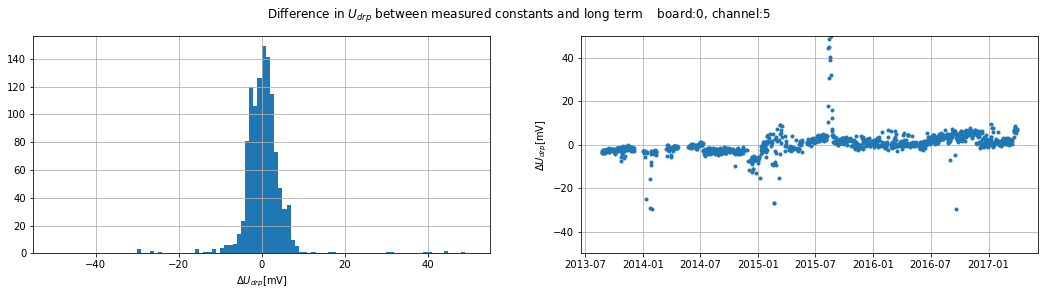

In [9]:
@interact(_id=IntSlider(min=0, max=319, value=5))
def plot_voltage_drop(_id):
    fig, (left, right) = plt.subplots(1, 2, figsize=(18, 4))

    b, ch = divmod(_id, 32)
    row = df[(df.b == b)&(df.ch ==ch)]
    
    (
        (row.voltage_drop - U_drp(lt_medians.loc[b, ch]))*1e3
    ).hist(bins=100, ax=left, range=[-50, 50])
    left.set_xlabel('$\Delta U_{drp}$[mV]')
    
    right.plot(
        (row.voltage_drop - U_drp(lt_medians.loc[b, ch]))*1e3, 
         '.'
    )
    right.set_ylabel('$\Delta U_{drp}$[mV]');
    right.set_ylim(-50, 50)
    right.grid()
    plt.suptitle('Difference in $U_{{drp}}$ between measured constants and long term    board:{0}, channel:{1}'.format(b,ch));

We see, the voltage drop (for this example channel) is fairly constant over time. We see some structures, but they do not result in differences in $U_{drp}$, which our bias voltage crate would try to counteract, because they are too small.
Note, the smallest change in voltage we can apply is ~20mV. 

So now, let's look at the width of the left distribution in the camera.

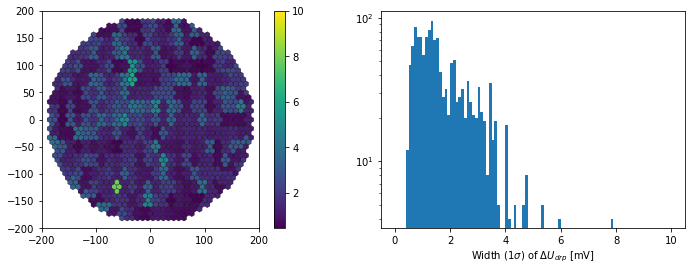

In [10]:
measured_voltage_drop_residual = []
for (b, ch), row in df.groupby(['b', 'ch']):
    delta_U_drp_in_mV = (row.voltage_drop - U_drp(lt_medians.loc[b, ch]))*1e3
    sigma = np.diff(delta_U_drp_in_mV.quantile([0.5-0.341, 0.5+0.341]).values)[0]/2
    measured_voltage_drop_residual.append({
        'bias_patch_id': b*32 + ch,
        'sigma_in_mV': sigma,
    })
measured_voltage_drop_residual = pd.DataFrame(measured_voltage_drop_residual)
measured_voltage_drop_residual = p.merge(measured_voltage_drop_residual, on='bias_patch_id')

fig, (left, right) = plt.subplots(1, 2, figsize=(12, 4))
img = camera(measured_voltage_drop_residual.sigma_in_mV, cmap='viridis', vmax=10, ax=left)
plt.colorbar(img, ax=left)

right.hist(measured_voltage_drop_residual.sigma_in_mV, log=True, range=[0, 10], bins=100);
right.set_xlabel('Width (1$\sigma$) of $\Delta U_{drp}$ [mV]');

We see one bias channel is special. It has a fairly wide distribution of about 8mV. This is channel 184. You can see its distribution below including it's temporal behavior. As we see, since ~2015 it behaves differently than before. The calibration constants are very noisy and show outliers. 

I think using the long term median here would even help, since the outliers most certainly do not represent the real behavior of the channel over the entire night. 

I looked at this channel already in the SiPM gain measurements and also in the raw-data. It was not looking suspicious, which explains why we did not yet discuss this channel.

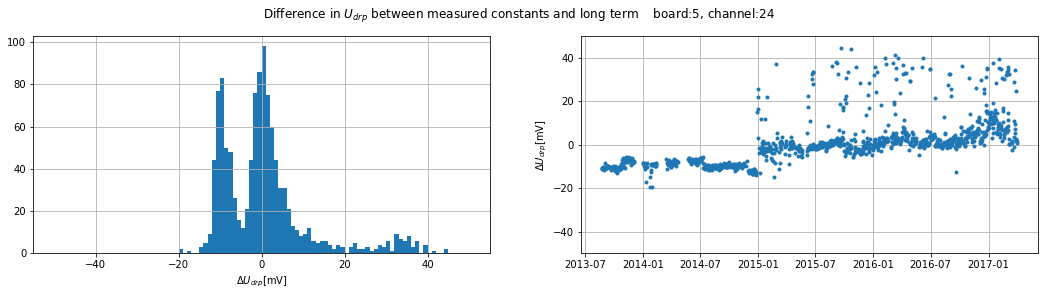

In [11]:
plot_voltage_drop(_id=184)